![](img/shutterstock_175625024.jpg)

# Ogólnie o uczeniu maszynowym i sieciach neuronowych

**Dlaczego?**  
* problemy które ciężko opisać klasycznymi algorytmami  
* problemy które są łatwe dla ludzi, ale nie znamy sposobu w jaki nasz mózg sobie z nimi radzi
* problemy dla których rozwiązanie ciągle się zmienia  

** Jak?**  
* zamiast pisać gotowe rozwiązanie - zbieramy dane z rozwiązaniem problemu  
* zadaniem algorytmu uczenia maszynowego jest "nauczenie się", które własności/cechy mają wpływ na odpowiedź
* dobry algorytm powinien nauczyć się ogólnych reguł, zamiast uczyć się "na pamięć" zbioru

**Co?**  
* rozpoznawanie wzorców  
* detekcja anomalii  
* przewidywanie - problem klasyfikacji/regresji

### Sieci neuronowe 

* bardzo ogólne pojęcie obejmujące szeroką klasę algorytmów
* wzorowane na budowie ludzkiego mózgu  
* każdy neuron zbiera sygnały od innych neuronów, i w zależności od kombinacji sygnałów aktywuje się lub nie
* różne struktury w mózgu mają różny cel - rozpoznawanie mowy, analiza obrazu, itp

![](img/neuron.jpg)

### Sztuczne sieci neuronowe

![](img/artificial_neuron.png)

* złożone z grup (warstw) neuronów komunikujących się ze sobą  
* najczęściej stosowane neurony są postaci jak na powyższej grafice - suma neuronów wejściowych przetransformowana jakąś funkcją  
* w przeciwieństwie do prawdziwych neuronów, nie są aktywowane tylko zero-jedynkowo, ale mogą też przyjmować wartości rzeczywiste  
* przykładowe sztuczne neurony:
    * liniowy: $y = \sum x_iw_i + b$
    * ReLU: $y = max(0, \sum x_iw_i + b)$
    * liniowy: $z = \sum x_iw_i + b, y = \frac{1}{1 + e^{-z}}$

![](img/ann.png)

# 1. Proste przykłady

In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


Na początek wygenerujmy dane z najprostszego modelu, tzn liniowego.
Zakładamy, że $y$ jest liniową transformacją $X = [x_1, x_2]$, tzn:  


$$ y = f(x_1, x_2) = XW + b = x_1 \cdot w_1 + x_2 \cdot w_2 + b$$


$W = [w_1, w_2]$ jest tutaj macierzą (wektorem) wag, a $b$ - wyrazem wolnym.

Zadaniem naszego algorytmu będzie poprawne znalezienie wartości $W$ i $b$ na podstawie danych.  

In [2]:
### generacja danych 
coefs = np.array([4, -2])
b = -5
X = np.random.uniform(low=-4, high=4, size = (1000,2))
y = X.dot(coefs) + b

# dodanie czynnika losowego
y += np.random.uniform(low=-1, high=1, size = y.shape)

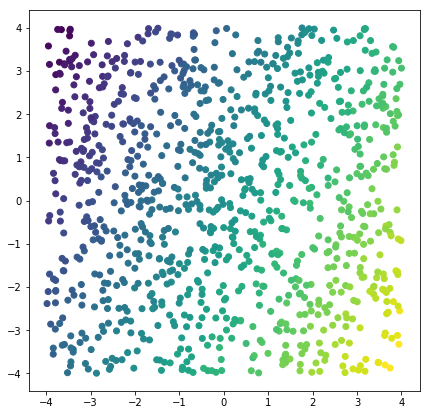

In [3]:
plt.figure(figsize=(7, 7))
plt.scatter(x=X[:, 0], y=X[:, 1], c=y)
plt.show()

** Jak wygląda proces uczenia modelu?**

Najpierw musimy zdefiniować nasz model. W tym przypadku optymalne będzie tutaj użycie neuronu liniowego przyjmującego na wejściu dwie wartości:  


$$ \hat{y} = \sum_{i} x_i w_i + b $$  

Następnie będziemy pokazywać modelowi po jednej obserwacji, i dla każdej z nich sprawdzać, czy jego wartość wyjściowa pokrywa się z prawdziwą wartością, czy nie. Na podstawie tego nastąpi mała aktualizacja wag $w_1$ i $w_2$.  

Tą procedurę będziemy powtarzać aż do uzyskania zadowalającego nas wyniku.

Aby nasz model był w stanie się czegokolwiek nauczyć, musimy zdefiniować jakąś miarę błędu, którą będziemy starali się zminimalizować.  
Dobrą miarą będzie tzw. błąd średniokwadratowy:

$$ MSE = \sum_{i=1}^n (y_i - \hat{y}_i)^2 $$

gdzie $y_i$ to prawdziwa wartość w $i$-tej obserwacji, a $\hat{y}_i$ to nasze przybliżenie.

W tym momencie nasz problem sprowadza się do prostego problemu optymalizacji:  
Jak dobrać współczynniki $w_1$ i $w_2$ tak, aby zmniejszyć błąd dla danej obserwacji?

Jak to w problemach optymalizacyjnych, posłużymy się pochodną.  

Załóżmy, że mamy dany wektor wejściowy $[x_1, x_2]$, prawdziwą wartość naszej funkcji $y$, wektor wag $[w_1, w_2]$ oraz wyraz wolny $b$.  

Zgodnie z budową neuronu, nasza predykcja ma wartość  

$$ \hat{y} = x_1 w_1 + x_2 w_2 + b $$

Podstawiając to do wzoru na MSE dostajemy  

$$ MSE = L(y) = (y - \hat{y})^2 = (y - x_1 w_1 + x_2 w_2 + b)^2 $$

Chcemy dopasować nasze parametry $w_1$ i $w_2$ tak, aby zminimalizować wartość funkcji $L(y)$. Musimy więć policzyć pochodne $\frac{\partial L}{\partial w_1}$, $\frac{\partial L}{\partial w_2}$ i $\frac{\partial L}{\partial b}$.  

$$ \frac{\partial L}{\partial w_1} = - 2 \cdot (y - x_1 w_1 + x_2 w_2 + b) \cdot x_1 $$  
$$ \frac{\partial L}{\partial w_2} = - 2 \cdot (y - x_1 w_1 + x_2 w_2 + b) \cdot x_2 $$  
$$ \frac{\partial L}{\partial b} = - 2 \cdot (y - x_1 w_1 + x_2 w_2 + b) $$  

W celu minimalizacji funkcji chcielibyśmy "iść" w kierunku przeciwnym do pochodnej.  
Proces obliczania kolejnych pochodnych nazywamy **propagacją wsteczną** (*backpropagation*).  
Cały algorytm optymalizacji wag zwie się **SGD** (*stochastic gradient descent*)

### Model liniowy z uczeniem online

In [4]:
w_1 = 0
w_2 = 0
b_hat = 0
step_size = 0.01
N_STEPS = 2000
for i in range(N_STEPS):
    index = i % X.shape[0]
    training_x = X[index]
    training_y = y[index]
    prediction = training_x[0]*w_1 + training_x[1]*w_2 + b_hat
    difference =  training_y - prediction
    loss = difference ** 2
    
    dw_1 = -2 * difference * training_x[0] 
    dw_2 = -2 * difference * training_x[1]
    db = -2 * difference 
    
    w_1 -= dw_1 * step_size
    w_2 -= dw_2 * step_size
    b_hat -= db * step_size
    
    # TODO: niech co 100 iteracji uczenia wypisze się średnie MSE (loss) na zbiorze treningowym

In [5]:
predictions = X.dot(np.array([w_1, w_2])) + b_hat

In [6]:
np.mean((predictions - y)**2)

0.35542633049653549

Ciekawostka: tak wygląda rozkład błędu w naszej przestrzeni parametrów $w_1$ i $w_2$

In [7]:
def calculate_mse_on_dataset(X, true_y, W, b):
    predictions = X.dot(W) + b
    return np.mean((predictions - true_y)**2)

In [8]:
w_1s = np.linspace(start=-8, stop=8, num=100)
w_2s = np.linspace(start=-8, stop=8, num=100)
w_s = np.array([[w_1, w_2] for w_1 in w_1s for w_2 in w_2s])
errors = np.zeros(shape = w_s.shape[0])
for i in range(w_s.shape[0]):
    errors[i] = calculate_mse_on_dataset(X, y, w_s[i], b)
    

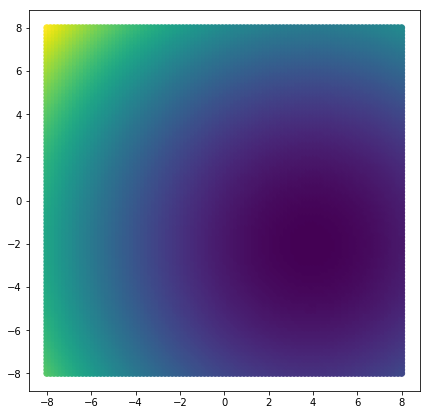

In [9]:
plt.figure(figsize=(7, 7))
plt.scatter(x=w_s[:, 0], y=w_s[:, 1], c=errors)
plt.show()

### Model liniowy z uczeniem w mini-batch'ach

Aktualizacja po jednej obserwacji może być w praktyce mało wydajna obliczeniowo, oraz obarczona sporym błędem spowodowanym dużą zmiennością między obserwacjami. Dlatego w praktyce stosuje się tzw. _mini-batch learning_ - funkcję błędu

In [10]:
coefs = np.array([4, -2])
b = -5
X = np.random.uniform(low=-4, high=4, size = (1000,2))
y = X.dot(coefs) + b

# dodanie czynnika losowego
y += np.random.uniform(low=-2, high=2, size = y.shape)

In [11]:
w_1 = 0
w_2 = 0
b_hat = 0
step_size = 0.01
N_STEPS = 200
BATCH_SIZE = 32
for i in range(N_STEPS):
    indexes = np.random.choice(range(X.shape[0]), size=BATCH_SIZE, replace=False)
    training_x = X[indexes]
    training_y = y[indexes]
    
    predictions = np.array([x_1*w_1 + x_2*w_2 + b_hat for (x_1, x_2) in training_x])
    difference =  training_y - predictions
    loss = np.mean(difference ** 2)
    
    # TODO: przelicz czy na pewno pochodna jest ok ;)
    
    dw_1 = -2 * np.mean(difference * training_x[:, 0])
    dw_2 = -2 * np.mean(difference * training_x[:, 1])
    db = -2 * np.mean(difference) 
    
    w_1 -= dw_1 * step_size
    w_2 -= dw_2 * step_size
    b_hat -= db * step_size

In [12]:
predictions = X.dot(np.array([w_1, w_2])) + b_hat
np.mean((predictions - y)**2)

1.2815646923196498

## 2. Notacja macierzowa

Przy większej ilości wag rozpisywanie każdej pochodnej z osobna byłoby uciążliwe. Dlatego wygodniej jest stosować notację macierzową.  

Niech $X$ będzie macierzą danych o wymiarach $n \times m$, $W$ będzie macierzą wag $m \times h$ a $b$ będzie macierzą wyrazów wolnych $n \times h$. Wtedy nasz model można zapisać jako 

$$ Y = XW + b $$

$Y$ jest teraz macierzą zawierającą aktywacje $h$ neuronów dla każdej z $n$ obserwacji w mini-batchu. **Uwaga**: macierz $b$ jest podstępna - każdy wiersz zawiera te same wartości (zastanów się dlaczego).

Aby uciec trochę od oklepanego już problemu regresji linowej, zmienimy trochę naturę problemu.

In [54]:
coefs_1 = np.array([4, -2])
b_1 = -5
coefs_2 = np.array([-3, -4])
b_2 =  1

X = np.random.uniform(low=-4, high=4, size = (1000,2))

Y = np.where(
    X.dot(coefs_1) + b_1 > X.dot(coefs_2) + b_2 + np.random.uniform(low=-2, high=2, size = y.shape),
    1, 
    0
).reshape(1000, 1)


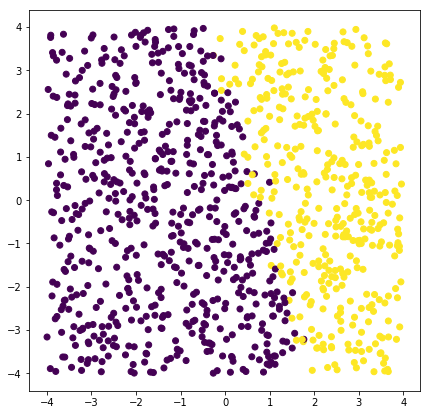

In [55]:
plt.figure(figsize=(7, 7))
plt.scatter(x=X[:, 0], y=X[:, 1], c=Y.reshape(1000,))
plt.show()

Tym razem naszym problemem jest klasyfikacja. Nasz poprzedni model zwracał nam wartość rzeczywistą, której nie jesteśmy w stanie przełożyć bezpośrednio na przynależność do jednej z dwóch klas. Wprowadzimy więc funkcję aktywacji zwaną sigmoid: 

$$ S (x) = \frac{1}{1 + e^{-x}} $$

Dostajemy więc przełożenie wartości rzeczywistej na wartość z przedziału $[0, 1]$

Mając już odpowiednią formę wyjścia z naszej sieci, potrzebujemy jeszcze funkcji straty - czyli informacji dla modelu, kiedy dokonał właściwej decyzji, a kiedy nie.  


Będziemy optymalizować funkcję straty 
$$ L(y, \hat{y}) = -\frac{1}{N} \sum_{n} y_{n}\ln{\hat{y_{n}}} +  (1-y_{n})\ln{(1-\hat{y_{n}})} $$

**Jak wygląda nasz model w konwencji macierzowej? **  
$H = XW + b$ - tutaj dokonujemy liniowej transformacji macierzy wejściowej  
$ \hat{Y} = S(H) $ - tutaj przekształcamy wyjście z poprzedniej operacji funkcją sigmoid. Przez $\sigma(H)$ rozumiemy tutaj macierz powstałą z zaaplikowania funkcji sigmoid do każdego elementu macierzy $H$  

**Jak przełożyć różniczkowanie na macierze?**  
Okazuje się, że naginając trochę konwencje zapisu, możemy korzystać z umownych operatorach różniczkowania macierzy. Tutaj omówię to bardzo pobieżnie - dla chętnych lektura: http://cs231n.stanford.edu/vecDerivs.pdf  

Zapiszmy naszą funkcję straty w postaci wektora:  
$$ L(Y, \hat{Y}) = Y \circ \ln{\hat{Y}} + (1-Y) \circ \ln{(1-\hat{Y})} $$

Symbol $\circ$ oznacza tutaj mnożenie po elementach.  
Wynikowy wektor L jest wektorem wartości funkcji straty dla każdej obserwacji.  

To co nas interesuje, to w jak wartości wag $W$ i $b$ wpływają na naszą funkcję straty $L$. Przekładając to na język matematyczny, interesują nas pochodne $\frac{\partial L}{\partial W} $ i $\frac{\partial L}{\partial b} $  
Aby je policzyć, skorzystamy z reguły łancuchowej:
$$ \frac{\partial L}{\partial W} = 
\frac{\partial L}{\partial \hat{Y}} \cdot 
\frac{\partial \hat{Y}}{\partial H} \cdot 
\frac{\partial H}{\partial W} $$

Ponieważ operujemy na macierzach, wynikowe pochodne też będą macierzami i musimy ustalić, które operacje mnożenia będą operacjami mnożenia macierzowego ($\cdot$), a które będą wynikały z mnożenia po elementach ($\circ$).  

Warto zauważyć, że niektóre przekształcenia zmieniają rozmiar macierzy (na przykład $H = XW + b$), a inne nie ($ \hat{Y} = S(H) $). Stąd łatwo się domyślić, kiedy musimy używać każdej z operacji. Ostatecznie mamy więc wzór   
$$ \frac{\partial L}{\partial W} = 
\frac{\partial L}{\partial \hat{Y}} \circ 
\frac{\partial \hat{Y}}{\partial H} \cdot 
\frac{\partial H}{\partial W} $$  



Poszczególne pochodne wyglądają następująco:

$$ \frac{\partial L}{\partial \hat{Y}} = \frac{Y}{\hat{Y}} - \frac{1-Y}{1-\hat{Y}}$$  
$$ \frac{\partial \hat{Y}}{\partial H} = S(H) \circ (1-S(H))$$
$$ \frac{\partial H}{\partial W} = X $$


In [15]:
def sigmoid(x):
    ################
    # TODO: zaimplementuj funkcję sigmoid tak, aby działała na numpy arrayach
    ################
    pass

In [16]:
D = 2 # number of inputs
K = 1 # number of outputs
W = np.zeros((D,K))
b = np.zeros((1,K))

# parametry 
step_size = 1e-0
reg = 1e-2

num_examples = X.shape[0]

for i in range(300):  
    # obliczamy scory oraz przynależności do klas przy aktualnych wagach
    scores = np.dot(X, W) + b 
    
    probs = sigmoid(scores)

    # obliczamy funkcję straty dla aktualnej predykcji
    
    loss = Y * np.log(probs) - (1-Y)*(np.log(1-probs))
    
    if i % 20 == 0:
        print("iteration %d: loss %f" % (i, np.mean(loss)))
    
    # wyliczamy gradient funkcji straty
    dL_dprobs = 1/num_examples * (Y-probs) # 1000x1
    dprobs_dH = probs *(1-probs) # 1000x1
    
    dL_dH = dL_dprobs * dprobs_dH # 1000x1
    
    # propagacja wsteczna
    dL_dW = np.dot(X.T, dL_dH) # 2x1
    dL_db = np.sum(dL_dH, axis=0, keepdims=True) # 1x1
    
    # aktualizujemy parametry
    W += -step_size * dL_dW
    b += -step_size * dL_db

iteration 0: loss -0.693147
iteration 20: loss -0.223552
iteration 40: loss -0.182516
iteration 60: loss -0.161308
iteration 80: loss -0.147476
iteration 100: loss -0.137438
iteration 120: loss -0.129684
iteration 140: loss -0.123441
iteration 160: loss -0.118266
iteration 180: loss -0.113879
iteration 200: loss -0.110096
iteration 220: loss -0.106786
iteration 240: loss -0.103858
iteration 260: loss -0.101242
iteration 280: loss -0.098886


In [17]:
scores = np.dot(X, W) + b 
probs = sigmoid(scores)
preds = (probs > 0.5).astype(int).reshape(1000,)

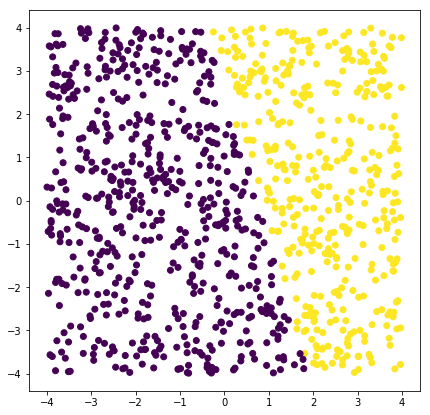

In [18]:
plt.figure(figsize=(7, 7))
plt.scatter(x=X[:, 0], y=X[:, 1], c=preds)
plt.show()

## 3. Warstwy ukryte

Póki co rozwiązywaliśmy problemy liniowe - zwykła transformacja liniowa pozwalała osiągnąć bardzo dobre wyniki. Co jednak się stanie jeśli zbiór danych nie będzie tak prosty?  


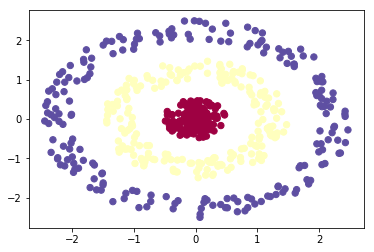

In [59]:
n_classes = 3
points_per_class = 200
X = np.zeros((points_per_class*n_classes, 2))
Y = np.zeros((points_per_class*n_classes, 3), dtype=int)
for i in range(n_classes):
    idx = range(points_per_class*i,points_per_class*(i+1))
    
    r = i + np.random.random(points_per_class)* 0.5 # 
    t = np.random.random(points_per_class) *2* np.pi
    
    X[idx] = np.c_[r*np.sin(t), r*np.cos(t)]
    Y[idx, i] = 1 # TODO: spojrzeć jak wygląda zakodowanie klas 

plt.scatter(X[:, 0], X[:, 1], c=np.argmax(Y, axis=1), s=40, cmap=plt.cm.Spectral)
plt.show()

Jak widzimy, w danych mamy trzy klasy - zadaniem algorytmu będzie zaklasyfikowanie obserwacji do jednej z klas. Potrzebujemy zatem dwóch rzeczy: funkcji aktywacyjnej, która zamieni 3-elementowe wyjście z neuronu na wektor trzech prawdopodobieństw sumujących się do 1, oraz funkcji straty, która odpowiednio "ukarze" algorytm za złe predykcje.  

Funkcją aktywacji której użyjemy jest *softmax*. Przyjmuje ona na wejściu wektor $a$ i zwraca również wektor, którego elementy są dane wzorem:

$$\sigma (a_j) = \frac{\exp{a_j}}{\sum_{i = 1}^{k} \exp{a_i}}$$  

Naturalną funkcją straty jest tutaj rozszerzenie *log-lossa* na wiele klas. Dla pojedynczej obserwacji wygląda ona następująco:

$$ L(y, \hat{y}) = \sum_{k=1}^{K} y_k \cdot \ln(\hat{y}_k) $$  
gdzie $y$ i $\hat{y}$ to odpowiednio wektor prawdziwych przynależności do klas i wektor prawdopodobieństw zwróconych przez model.  

**Nasz model wygląda więc następujaco:**  
$H = XW + b$ - tutaj dokonujemy liniowej transformacji macierzy wejściowej  
$ \hat{Y} = \sigma(H) $ - przekształcenie wyjścia z poprzedniej sieci funkcją sigmoid $H$  

Tak samo jak wcześniej, skorzystamy z reguły łańcuchowej w celu policzenia odpowiednich pochodnych. Aby uprościć obliczenia, można obliczyć pochodną funkcji $L$ od razu po wartościach $H$:  

Przez $h$ oznaczmy wiersz z macierzy $H$. W kolejnym kroku dokonujemy transformacji $\sigma(H)$, więc możemy napisać że $\hat{y}_j = \frac{\exp{h_j}}{\sum_{i = 1}^{k} \exp{h_i}}$. Następnie za pomocą otrzymanych wartości liczymy funkcję straty $L(y, \hat{y})$.  

Po dość prostych obliczeniach dostajemy 
$$\frac{\partial L}{\partial h_j} = \hat{y_j} - y_j$$  

**TODO: przeliczyć w domu i sprawdzić czy faktycznie tak jest**

In [66]:
D = 2
K = 3
W = np.zeros((D,K))
b = np.zeros((1,K))

# parametry 
step_size = 1e-4
reg = 1e-2

num_examples = X.shape[0]

for i in range(200):  
    # obliczamy scory oraz przynależności do klas przy aktualnych wagach
    scores = np.dot(X, W) + b 
    
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # obliczamy funkcję straty dla aktualnej iteracji
    loss_matrix = -np.log(probs) * Y
    mean_loss = np.mean(loss_matrix)
    
    if i % 20 == 0:
        print("iteration %d: loss %f" % (i, mean_loss))

    # wyliczamy gradient funkcji straty
    dL_dH = probs - Y
    
    # propagacja wsteczna
    
    dW = np.dot(X.T, dL_dH)
    db = np.sum(dL_dH, axis=0, keepdims=True)

    # dodajemy jeszcze wpływ regularyzacji do gradientu wag
    dW += reg * W

    # aktualizujemy parametry
    W += -step_size * dW
    b += -step_size * db

iteration 0: loss 0.366204
iteration 20: loss 0.366029
iteration 40: loss 0.365959
iteration 60: loss 0.365931
iteration 80: loss 0.365919
iteration 100: loss 0.365915
iteration 120: loss 0.365913
iteration 140: loss 0.365912
iteration 160: loss 0.365912
iteration 180: loss 0.365912


overall accuracy: 0.39


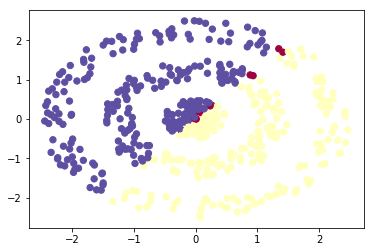

In [61]:
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1) # nie musimy wyliczać konkretnych prawdopodobienstw - exp jest funkcją rosnącą
print('overall accuracy: %.2f' % (np.mean(predicted_class == np.argmax(Y, 1))))

plt.scatter(X[:, 0], X[:, 1], c=predicted_class, s=40, cmap=plt.cm.Spectral)
plt.show()

Widać ewidentnie, że model nie jest w stanie dopasować się do tego zbioru. Spróbujmy zatem dodać dodatkową warstwę między wejściem a wyjściem.

#### Jedna warstwa ukryta

In [68]:
D = 2
K = 3
h = 12 # size of hidden layer
W = np.zeros((D,h)) 
b = np.zeros((1,h))
W2 = np.zeros((h,K)) 
b2 = np.zeros((1,K))

# parametry 
step_size = 1e-2
reg = 5e-2 # regularization strength


num_examples = X.shape[0]
for i in range(100):  
    # obliczamy scory oraz przynależności do klas przy aktualnych wagach
    hidden_layer = np.maximum(0, np.dot(X, W) + b) # warstwa ukryta - stosujemy funkcję aktywacyjną ReLU
    scores = np.dot(hidden_layer, W2) + b2 # warstwa końcowa

    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # obliczamy funkcję straty dla aktualnej predykcji
    loss_matrix = -np.log(probs) * Y
    mean_loss = np.mean(loss_matrix)
    if i % 20 == 0:
        print("iteration %d: loss %f" % (i, mean_loss))

    # wyliczamy gradient funkcji straty
    dL_dH = probs - Y
    #dL_dH /= num_examples
    
    # it's backpropagation time!
    # najpierw badamy wpływ wag i stałej w ostatniej warstwie
    dW2 = np.dot(hidden_layer.T, dL_dH)
    db2 = np.sum(dL_dH, axis=0, keepdims=True)
    
    # następnie liczymy gradient dla wartości w warstwie ukrytej
    dhidden = np.dot(dL_dH, W2.T)
    # pamietamy o uwzględnieniu pochodnej funkcji aktywacyjnej - na szczęście jest dość prosta
    dhidden[hidden_layer <= 0] = 0
    # na koniec dostajemy gradienty dla pierwszej warstwy
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)

    # dodajemy jeszcze wpływ regularyzacji do gradientu wag
    dW2 += reg * W2
    dW += reg * W

    # aktualizujemy parametry
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

iteration 0: loss 0.366204
iteration 20: loss 0.366204
iteration 40: loss 0.366204
iteration 60: loss 0.366204
iteration 80: loss 0.366204


Sieć się w ogóle nie uczy. **TODO: burza mózgów - dlaczego?**

overall accuracy: 0.33


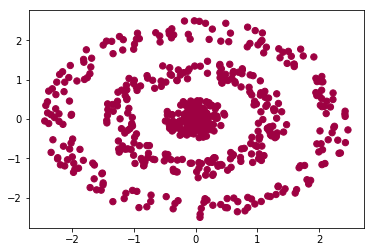

In [71]:
hidden = np.dot(X, W) + b
scores = np.dot(hidden, W2) + b2
predicted_class = np.argmax(scores, axis=1) # nie musimy wyliczać konkretnych prawdopodobienstw - exp jest funkcją rosnącą
print('overall accuracy: %.2f' % (np.mean(predicted_class == np.argmax(Y, 1))))

plt.scatter(X[:, 0], X[:, 1], c=predicted_class, s=40, cmap=plt.cm.Spectral)
plt.show()

In [70]:
####################
#miejsce na naprawienie błędu
####################

Wciąż nie ma poprawy - dlaczego? **TODO: zastanowić się czemu**

#### Warstwa ukryta z aktywacją relu

In [24]:
def relu(x):
    """
    Only for numpy arrays!!
    """
    return np.maximum(x, 0, x)

In [25]:
D = 2
K = 3
h = 15 # size of hidden layer
W = 1 * np.random.randn(D,h) #np.zeros((D,K)) 
b = np.zeros((1,h))
W2 = 1 * np.random.randn(h,K) #np.zeros((D,K)) 
b2 = np.zeros((1,K))

# parametry 
step_size = 1e-1
reg = 5e-2 # regularization strength


num_examples = X.shape[0]
for i in range(200):  
    # obliczamy scory oraz przynależności do klas przy aktualnych wagach
    hidden_layer = np.maximum(0, np.dot(X, W) + b) # warstwa ukryta - stosujemy funkcję aktywacyjną ReLU
    hidden_activation = relu(hidden_layer)
    scores = np.dot(hidden_activation, W2) + b2 # warstwa końcowa

    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # obliczamy funkcję straty dla aktualnej predykcji
    loss_matrix = -np.log(probs) * Y
    mean_loss = np.mean(loss_matrix)
    if i % 20 == 0:
        print("iteration %d: loss %f" % (i, mean_loss))

    # wyliczamy gradient funkcji straty
    dL_dH = probs - Y
    dL_dH /= num_examples
    
    # it's backpropagation time!
    # najpierw badamy wpływ wag i stałej w ostatniej warstwie
    dW2 = np.dot(hidden_layer.T, dL_dH)
    db2 = np.sum(dL_dH, axis=0, keepdims=True)
    
    # następnie liczymy gradient dla wartości w warstwie ukrytej
    dhidden = np.dot(dL_dH, W2.T)
    # pamietamy o uwzględnieniu pochodnej funkcji aktywacyjnej ReLu 
    dhidden[hidden_layer <= 0] = 0
    
    # na koniec dostajemy gradienty dla pierwszej warstwy
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)

    # dodajemy jeszcze wpływ regularyzacji do gradientu wag
    dW2 += reg * W2
    dW += reg * W

    # aktualizujemy parametry
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

iteration 0: loss 0.970192
iteration 20: loss 0.268007
iteration 40: loss 0.226472
iteration 60: loss 0.211394
iteration 80: loss 0.203788
iteration 100: loss 0.196148
iteration 120: loss 0.192320
iteration 140: loss 0.189418
iteration 160: loss 0.186867
iteration 180: loss 0.185169


overall accuracy: 0.98


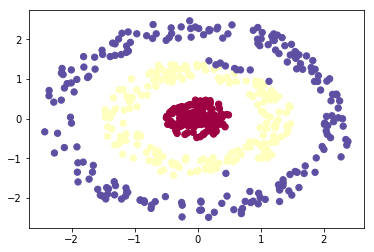

In [26]:
hidden = np.dot(X, W) + b
hidden = relu(hidden)
scores = np.dot(hidden, W2) + b2
predicted_class = np.argmax(scores, axis=1) # nie musimy wyliczać konkretnych prawdopodobienstw - exp jest funkcją rosnącą
print('overall accuracy: %.2f' % (np.mean(predicted_class == np.argmax(Y, 1))))

plt.scatter(X[:, 0], X[:, 1], c=predicted_class, s=40, cmap=plt.cm.Spectral)
plt.show()

** Uff - teraz działa**.  

Tutaj warto wspomnieć, że sieci neuronowe są uniwersalnymi aproksymatorami - to jest, dla dowolnej funkcji istnieje konkretna sieć neuronowa (przez sieć rozumiemy tutaj zarówno jej architekturę, jak i konkretne wagi) która dowolnie dobrze jest w stanie przybliżyć tą funkcję.  
Jeśli więc wiemy, że istnieje funkcja która z naszego $X$ daje nam $y$, to istnieje też sieć neuronowa któa będzie tą funkcję imitować. To, co realizujemy podczas uczenia (i projektowania sieci) jest poszukiwaniem tej funkcji. 

# 4. Keras

Wszystko fajnie, ale po co się męczyć? Z pomocą przychodzi pakiet `keras`.  
**TODO: obowiązkowo odwiedzić** https://keras.io/

In [27]:
import keras

Podstawowym obiektem z którego będziemy korzystać jest `Sequential`. Pozwala on na budowę podstawowych modelu, w których każda warstwa łączy się z jedną poprzednią. W zupełności wystarczy to do naszych zastosowań. 

In [28]:
from keras import Sequential

Teraz kolej na dodawanie do modelu kolejnych warstw. Na razie będziemy korzystać z warstw `Dense` i `Activation`. Warstwy możecie zaimportować z modułu keras.layers

In [29]:
from keras.layers import Dense, Activation

Czas na zbudowanie modelu. Stwórzmy model analogiczny do tego z poprzedniego kroku. 

In [30]:
# najpierw inicjalizujemy pusty model
model = Sequential()
# następnie dodajemy warstwy w kolejności w jakiej mają znaleźć się w sieci
# w pierwszej warstwie modelu musimy powiedzieć jakiego rozmiaru będzie wejście. 
# Dalej nie musimy już tego robić, keras sam się domyśli

model.add(Dense(15, input_dim=2)) 
model.add(Activation('relu')) # dodanie funkcji aktywacyjnej na warstwie ukrytej. 
# TODO: przejrzeć jakie są inne funkcje aktywacyjne
model.add(Dense(3))
model.add(Activation('softmax'))

Mając gotową architekturę sieci, musimy model "skompilować". W kerasie oznacza to ustalenie funkcji straty i algorytmu optymalizującego. My skorzystamy z *log lossa* (w kerasie `categorical_crossentropy`) i metody optymalizacji SGD.

In [31]:
model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
)

Uczenie modelu polega na wywałaniu metody `fit` - czyli dopasowania się do danych treningowych.  
**TODO: przeczytać** https://keras.io/models/sequential/  
Ważne: w przypadku klasyfikacji keras wymaga zawsze danych w postaci *one-hot encoding* - na szczęście nasze już są w tym formacie.

In [32]:
model.fit(x=X, y=Y, epochs=20, verbose = 0, batch_size=600) 

In [33]:
preds = model.predict(X)
print('training accuracy: %.2f' % (np.mean(np.argmax(preds, axis=1) == np.argmax(Y, axis=1))))

training accuracy: 0.30


Widzimy, że model wolno się uczy. Stwórzmy model od nowa (aby zresetować go do stanu początkowego) i sprawdźmy co się dzieje (parametr `verbose=1`).

In [72]:
########
########

### Boston housing

Czas na zbudowanie modelu na rzeczywistych danych. Keras udostępnia sporo gotowych zbiorów - skorzystamy teraz z jednego z nich.   
Zbiór `boston_housing` zawiera dane na temat 506 domów w bostonie. Wartością, którą chcemy przewidzieć jest mediana ceny domów w danej okolicy.  
**TODO:** Dokładniejszy opis danych: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

In [34]:
from keras.datasets import boston_housing 

In [35]:
(X_train_boston, Y_train_boston), (X_test_boston, Y_test_boston) = boston_housing.load_data()
print(X_train_boston.shape)

(404, 13)


**Przerywnik - o walidacji modeli**  
Budując model, chcemy mieć informację czego możemy się po nim spodziewać pod kątem skuteczności. Procedura, którą stosowaliśmy wcześniej jest błędna - testowaliśmy model na tych samych obserwacjach, na któych model się uczył. Stosując model produkcyjnie, będziemy mu dawać obserwacje których nigdy nie miał okazji widzieć wcześniej, więc wypadałoby uwzględnić to podczas procedury testowania modelu. Stąd domyślny podział danych na dwie części.

In [36]:
# przykładowy wiersz
X_train_boston[0, :]

array([   1.23247,    0.     ,    8.14   ,    0.     ,    0.538  ,
          6.142  ,   91.7    ,    3.9769 ,    4.     ,  307.     ,
         21.     ,  396.9    ,   18.72   ])

**TODO: zbudować model bez żadnej warstwy ukrytej - tzn tylko wejście i wyjście. Zaproponować jakąś miarę błędu na zbiorze testowym i obliczyć ją.**

In [37]:
def MAE(y_true, y_pred):
    """
    Calculates Mean Absolute Error 
    """
    return np.mean(np.abs(y_true - y_pred))

In [38]:
model_boston_linear = Sequential()
model_boston_linear.add(Dense(1, input_dim=13))
model_boston_linear.add(Activation('linear'))

model_boston_linear.compile(optimizer='sgd', loss="mean_squared_error")

model_boston_linear.fit(X_train_boston, Y_train_boston, epochs=20, batch_size=404, verbose = 1)

Epoch 1/20
404/404 [==============================] - 0s 167us/step - loss: 20837.3301
Epoch 2/20
404/404 [==============================] - 0s 6us/step - loss: 733799972864.0000
Epoch 3/20
404/404 [==============================] - 0s 5us/step - loss: 28008086193733369856.0000
Epoch 4/20
404/404 [==============================] - 0s 5us/step - loss: 1069507984236678997767880704.0000
Epoch 5/20
404/404 [==============================] - 0s 6us/step - loss: 40839986043355616604638530106294272.0000
Epoch 6/20
404/404 [==============================] - 0s 5us/step - loss: inf
Epoch 7/20
404/404 [==============================] - 0s 5us/step - loss: inf
Epoch 8/20
404/404 [==============================] - 0s 5us/step - loss: inf
Epoch 9/20
404/404 [==============================] - 0s 5us/step - loss: inf
Epoch 10/20
404/404 [==============================] - 0s 19us/step - loss: inf
Epoch 11/20
404/404 [==============================] - 0s 5us/step - loss: inf
Epoch 12/20
404/404 [======

Jak widać, funkcja straty wybucha do nieskonczoności. Jeśli sprawdzicie wartość wag w modelu (**TODO**: model_boston_linear.get_weights()), zapewne też będą miały wartość `inf`.  
**TODO**: burza mózgów - dlaczego tak się dzieje?

In [73]:
######

######

In [39]:
class Scaler():
    def __init__(self):
        pass
        
    def scale_train(self, X):
        pass
    
    def scale_test(self, X):
        pass
        

In [40]:
scaler = Scaler()
X_train_boston_scaled = scaler.scale_train(X_train_boston)
X_test_boston_scaled = scaler.scale_test(X_train_boston)

In [41]:
model_boston_linear = Sequential()
model_boston_linear.add(Dense(1, input_dim=13))
model_boston_linear.add(Activation('linear'))

model_boston_linear.compile(optimizer='sgd', loss="mean_squared_error")

model_boston_linear.fit(X_train_boston_scaled, Y_train_boston, epochs=20, batch_size=404, verbose = 1)

Epoch 1/20
404/404 [==============================] - 0s 199us/step - loss: 621.6411
Epoch 2/20
404/404 [==============================] - 0s 4us/step - loss: 560.9384
Epoch 3/20
404/404 [==============================] - 0s 4us/step - loss: 507.2841
Epoch 4/20
404/404 [==============================] - 0s 4us/step - loss: 459.8538
Epoch 5/20
404/404 [==============================] - 0s 4us/step - loss: 417.9191
Epoch 6/20
404/404 [==============================] - 0s 6us/step - loss: 380.8372
Epoch 7/20
404/404 [==============================] - 0s 6us/step - loss: 348.0406
Epoch 8/20
404/404 [==============================] - 0s 6us/step - loss: 319.0281
Epoch 9/20
404/404 [==============================] - 0s 6us/step - loss: 293.3572
Epoch 10/20
404/404 [==============================] - 0s 4us/step - loss: 270.6374
Epoch 11/20
404/404 [==============================] - 0s 6us/step - loss: 250.5236
Epoch 12/20
404/404 [==============================] - 0s 4us/step - loss: 232.7113

In [42]:
test_predictions_boston = model_boston_linear.predict(X_train_boston_scaled)
print(MAE(y_pred=test_predictions_boston, y_true=Y_test_boston))

9.53095997298


### Rozpoznawanie pisma

Przejdziemy teraz do wykorzystania sieci neuronowych przy analizie obrazu. Będziemy zajmować się zbiorem MNIST, który zawiera zdjęcia ręcznie pisanych cyfr. Naszym zadaniem będzie nauczenie sieci rozpoznawania cyfr.  
Najpierw musimy pobrać zbiór danych:  

In [43]:
from keras.datasets import mnist
(X_train_mnist, Y_train_mnist), (X_test_mnist, Y_test_mnist) = mnist.load_data()
print(X_train_mnist.shape)
print(Y_train_mnist.shape)

(60000, 28, 28)
(60000,)


5


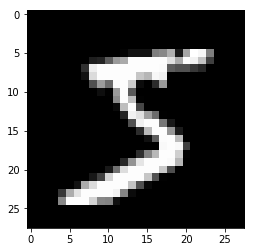

In [44]:
digit = X_train_mnist[0]
print(Y_train_mnist[0])
plt.imshow(digit, interpolation = "nearest", cmap = "gray")
plt.show()

**TODO**: zbadaj, jak zapisywane są dane o odcieniach szarości w macierzy reprezentującej cyfrę, i zaproponuj sposób na sprowadzenie danych do formatu akceptowalnego przez sieć.

In [74]:
########
########

In [46]:
from keras.utils import to_categorical

In [47]:
model_mnist = Sequential()
model_mnist.add(Dense(200, input_dim=28*28))
model_mnist.add(Activation('relu'))
model_mnist.add(Dense(10))
model_mnist.add(Activation('softmax'))

model_mnist.compile(optimizer="sgd", loss="categorical_crossentropy")

model_mnist.fit(X_train_mnist, to_categorical(Y_train_mnist), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.6299
Epoch 2/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.3337
Epoch 3/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.2843
Epoch 4/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.2533
Epoch 5/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.2302
Epoch 6/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.2115
Epoch 7/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.1961
Epoch 8/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.1828
Epoch 9/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.1711
Epoch 10/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.1607


In [48]:
preds_mnist = model_mnist.predict(X_test_mnist_reshaped)
print('test accuracy: %.2f' % (np.mean(np.argmax(preds_mnist, axis=1) == Y_test_mnist)))

test accuracy: 0.96


Czy na pewno nasz model nauczył się "widzieć" i rozpoznawać cyfry? Sprawdźmy co się stanie, jeśli każdą obserwację w zbiorze przemieszamy za pomocą tej samej permutacji.

In [49]:
shuffler = np.random.permutation(X_train_mnist_reshaped.shape[1])

In [50]:
X_train_mnist_shuffled = X_train_mnist_reshaped[:, shuffler]
X_test_mnist_shuffled = X_test_mnist_reshaped[:, shuffler]

5


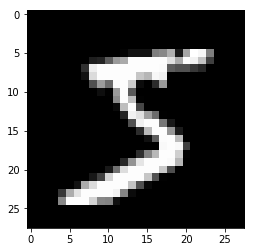

In [51]:
digit = X_train_mnist_reshaped[0].reshape((28, 28))
print(Y_train_mnist[0])
plt.imshow(digit, interpolation = "nearest", cmap = "gray")
plt.show()

5


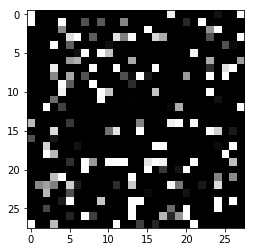

In [52]:
digit = X_train_mnist_shuffled[0].reshape((28, 28))
print(Y_train_mnist[0])
plt.imshow(digit, interpolation = "nearest", cmap = "gray")
plt.show()

In [53]:
model_mnist_shuffled = Sequential()
model_mnist_shuffled.add(Dense(200, input_dim=28*28))
model_mnist_shuffled.add(Activation('relu'))
model_mnist_shuffled.add(Dense(10))
model_mnist_shuffled.add(Activation('softmax'))

model_mnist_shuffled.compile(optimizer="sgd", loss="categorical_crossentropy")

model_mnist_shuffled.fit(X_train_mnist_shuffled, to_categorical(Y_train_mnist), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 10s 162us/step - loss: 0.6298
Epoch 2/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.3300
Epoch 3/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.2829
Epoch 4/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.2530
Epoch 5/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.2304
Epoch 6/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.2121
Epoch 7/10
60000/60000 [==============================] - 10s 162us/step - loss: 0.1961
Epoch 8/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.1827
Epoch 9/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.1711
Epoch 10/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.1609


Okazuje się, że model nie działa w sposób analogiczny do tego, jak my postrzegamy świat. To co dla nas jest chmurą losowych punktów, dla modelu jest cyfrą. Wynika to z tej akurat konkretnie archutektury sieci - model nie bierze pod uwagę korelacji między pikselami leżącymi obok siebie, i traktuje każdy jako niezależną zmienną - co jest oczywiście założeniem zupełnie błędnym.

**TODO (grube): poczytać (nawet pobieżnie) o sieciach (warstwach) konwolucyjnych.** 

Źródła, dodatkowe czytajki, zajawki:
* https://www.coursera.org/learn/neural-networks - kurs "ojca" sieci neuronowych od podstaw  
* http://cs231n.github.io/ - trochę bardziej zaawansowany  
* http://www.asimovinstitute.org/neural-network-zoo/ - fajna ogólna opowieść
* ogólnie coursera
* http://cs231n.stanford.edu/vecDerivs.pdf - zostawiam też tu, dla przypomnienia
* https://www.youtube.com/watch?v=qv6UVOQ0F44 - MarIO
* https://www.youtube.com/watch?v=dqxqbvyOnMY - przetwarzanie obrazu za pomocą GAN-ów
